# brmspy - Estimating Multivariate Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1z5F2qOHsUfIpVg-ntFRCuZC0-wCZwJEp)

**Example adapted from: [HERE](https://cran.r-project.org/web/packages/brms/vignettes/brms_multivariate.html)**

In [1]:

import os
import sys

import sys, os # for running from repo
sys.path.insert(0, os.path.abspath("../../"))

try: from brmspy import brms; import seaborn;
except ImportError:
    %pip install -q brmspy seaborn
    from brmspy import brms

from brmspy.brms import set_rescor, bf, lf

import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

renv = "multivariate-models"

if not brms.environment_exists(renv):
    with brms.manage(environment_name=renv) as ctx:
        ctx.install_runtime()
        ctx.install_rpackage("MCMCglmm")
else:
    brms.environment_activate(renv)

[brmspy][_call_with_frames_removed] Running autoload!
[brmspy][_autoload] Activating runtime /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0
[brmspy][_autoload] lib paths are ['/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/library', '/Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/Rlib']
[brmspy][_autoload] Setting cmdstan path to /Users/sebastian/.brmspy/runtime/macos-arm64-r4.5-0.2.0/cmdstan


## Introduction

In the present example, we want to discuss how to specify multivariate multilevel models using brms. We call a model multivariate if it contains multiple response variables, each being predicted by its own set of predictors. Consider an example from biology. Hadfield, Nutall, Osorio, and Owens (2007) analyzed data of the Eurasian blue tit (https://en.wikipedia.org/wiki/Eurasian_blue_tit). They predicted the tarsus length as well as the back color of chicks. Half of the brood were put into another fosternest, while the other half stayed in the fosternest of their own dam. This allows to separate genetic from environmental factors. Additionally, we have information about the hatchdate and sex of the chicks (the latter being known for 94% of the animals).

In [2]:
df = brms.get_data("BTdata", package = "MCMCglmm")
df.head()

,tarsus,back,animal,dam,fosternest,hatchdate,sex
1,-1.892297,1.146421,R187142,R187557,F2102,-0.687402,Fem
2,1.136110,-0.759652,R187154,R187559,F1902,-0.687402,Male
3,0.984689,0.144937,R187341,R187568,A602,-0.427981,Male
4,0.379008,0.255585,R046169,R187518,A1302,-1.465664,Male
5,-0.075253,-0.300699,R046161,R187528,A2602,-1.465664,Fem


## Basic Multivariate Models

We begin with a relatively simple multivariate normal model.

In [3]:
bform1 = bf("""
mvbind(tarsus, back) ~
    sex + 
    hatchdate + 
    (1|p|fosternest) + 
    (1|q|dam)
""") + set_rescor(rescor=True)

fit1 = brms.brm(bform1, data = df, chains = 2, cores = 2, silent = 2, refresh = 0)

[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...
[brmspy][worker_main] Fit done!


As can be seen in the model code, we have used mvbind notation to tell brms that both tarsus and back are separate response variables. The term (1|p|fosternest) indicates a varying intercept over fosternest. By writing |p| in between we indicate that all varying effects of fosternest should be modeled as correlated. This makes sense since we actually have two model parts, one for tarsus and one for back. The indicator p is arbitrary and can be replaced by other symbols that comes into your mind (for details about the multilevel syntax of brms, see help("brmsformula") and vignette("brms_multilevel")). Similarly, the term (1|q|dam) indicates correlated varying effects of the genetic mother of the chicks. Alternatively, we could have also modeled the genetic similarities through pedigrees and corresponding relatedness matrices, but this is not the focus of this vignette (please see vignette("brms_phylogenetics")). The model results are readily summarized via



In [4]:
for var in fit1.idata.posterior_predictive.data_vars:
    print(var)
    print(az.loo(fit1.idata, var_name=var))
    print("\n")

tarsus


/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 828 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2905.97    15.70
p_loo     2104.33        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  828  100.0%



back
Computed from 2000 posterior samples and 828 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1488.51     1.91
p_loo      523.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      182   22.0%
   (0.70, 1]   (bad)       626   75.6%
   (1, Inf)   (very bad)   20    2.4%





/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [5]:
brms.summary(fit1)

 Family: MV(gaussian, gaussian) 
  Links: mu = identity
         mu = identity 
Formula: tarsus ~ sex + hatchdate + (1 | p | fosternest) + (1 | q | dam) 
         back ~ sex + hatchdate + (1 | p | fosternest) + (1 | q | dam) 
   Data: structure(list(tarsus = c(-1.89229718155107, 1.136 (Number of observations: 828) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~dam (Number of levels: 106) 
                                     Estimate Est.Error l-95% CI u-95% CI Rhat
sd(tarsus_Intercept)                     0.49      0.05     0.39     0.60 1.00
sd(back_Intercept)                       0.24      0.08     0.09     0.39 1.02
cor(tarsus_Intercept,back_Intercept)    -0.52      0.23    -0.95    -0.04 1.01
                                     Bulk_ESS Tail_ESS
sd(tarsus_Intercept)                      655     1202
sd(back_Intercept)                        233      458
cor(tarsus_Intercept,back_Intercept)

The summary output of multivariate models closely resembles those of univariate models, except that the parameters now have the corresponding response variable as prefix. Across dams, tarsus length and back color seem to be negatively correlated, while across fosternests the opposite is true. This indicates differential effects of genetic and environmental factors on these two characteristics. Further, the small residual correlation rescor(tarsus, back) on the bottom of the output indicates that there is little unmodeled dependency between tarsus length and back color. Although not necessary at this point, we have already computed and stored the LOO information criterion of fit1, which we will use for model comparisons. Next, let’s take a look at some posterior-predictive checks, which give us a first impression of the model fit.

<Axes: xlabel='tarsus'>

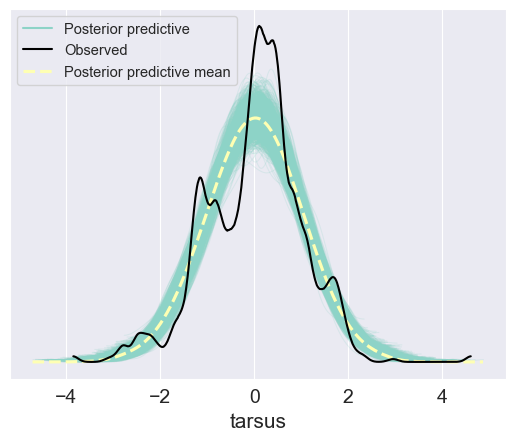

In [6]:
az.plot_ppc(fit1.idata, var_names=['tarsus'])

<Axes: xlabel='back'>

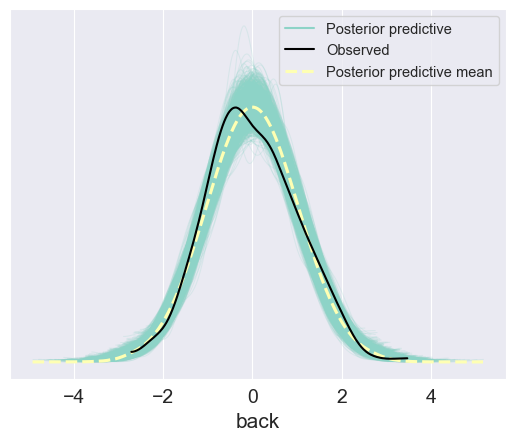

In [7]:
az.plot_ppc(fit1.idata, var_names=["back"])

This looks pretty solid, but we notice a slight unmodeled left skewness in the distribution of tarsus. We will come back to this later on. Next, we want to investigate how much variation in the response variables can be explained by our model and we use a Bayesian generalization of the 𝑅2
 coefficient.

In [8]:
brms.call("bayes_R2", fit1)

,Estimate,Est.Error,Q2.5,Q97.5
R2tarsus,0.435203,0.198050,0.023223,0.027383
R2back,0.388903,0.142697,0.479798,0.250811


Clearly, there is much variation in both animal characteristics that we can not explain, but apparently we can explain more of the variation in tarsus length than in back color.

## More Complex Multivariate Models

Now, suppose we only want to control for sex in tarsus but not in back and vice versa for hatchdate. Not that this is particular reasonable for the present example, but it allows us to illustrate how to specify different formulas for different response variables. We can no longer use mvbind syntax and so we have to use a more verbose approach:

In [9]:
bf_tarsus = bf("tarsus ~ sex + (1|p|fosternest) + (1|q|dam)")
bf_back = bf("back ~ hatchdate + (1|p|fosternest) + (1|q|dam)")

fit2 = brms.brm(bf_tarsus + bf_back + set_rescor(True), data = df, chains = 2, cores = 2, silent = 2, refresh = 0)

[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...
[brmspy][worker_main] Fit done!


Note that we have literally added the two model parts via the + operator, which is in this case equivalent to writing mvbf(bf_tarsus, bf_back). See help("brmsformula") and help("mvbrmsformula") for more details about this syntax. Again, we summarize the model first.

In [10]:
for var in fit2.idata.posterior_predictive.data_vars:
    print(var)
    print(az.loo(fit2.idata, var_name=var))
    print("\n")

tarsus


/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 828 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2920.82    14.77
p_loo     2119.06        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  828  100.0%



back
Computed from 2000 posterior samples and 828 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1492.26     1.79
p_loo      528.38        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      149   18.0%
   (0.70, 1]   (bad)       661   79.8%
   (1, Inf)   (very bad)   18    2.2%





/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [11]:
brms.summary(fit2)

 Family: MV(gaussian, gaussian) 
  Links: mu = identity
         mu = identity 
Formula: tarsus ~ sex + (1 | p | fosternest) + (1 | q | dam) 
         back ~ hatchdate + (1 | p | fosternest) + (1 | q | dam) 
   Data: structure(list(tarsus = c(-1.89229718155107, 1.136 (Number of observations: 828) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Multilevel Hyperparameters:
~dam (Number of levels: 106) 
                                     Estimate Est.Error l-95% CI u-95% CI Rhat
sd(tarsus_Intercept)                     0.48      0.05     0.39     0.58 1.00
sd(back_Intercept)                       0.25      0.07     0.11     0.39 1.00
cor(tarsus_Intercept,back_Intercept)    -0.50      0.22    -0.93    -0.07 1.00
                                     Bulk_ESS Tail_ESS
sd(tarsus_Intercept)                      977     1316
sd(back_Intercept)                        356      784
cor(tarsus_Intercept,back_Intercept)      643      902

Let’s find out, how model fit changed due to excluding certain effects from the initial model:

In [12]:
var = "back"
loo1 = az.loo(fit1.idata, var_name=var)
loo2 = az.loo(fit2.idata, var_name=var)
cmp = az.compare({"m1": fit1.idata, "m2": fit2.idata}, ic="loo", var_name=var)
cmp

/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/sebastian

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m1,0,-1488.510819,523.891116,0.000000,1.000000e+00,1.906331,0.000000,True,log
m2,1,-1492.264498,528.376009,3.753679,7.993606e-15,1.793305,2.450533,True,log


Apparently, there is no noteworthy difference in the model fit. Accordingly, we do not really need to model sex and hatchdate for both response variables, but there is also no harm in including them (so I would probably just include them).

To give you a glimpse of the capabilities of brms’ multivariate syntax, we change our model in various directions at the same time. Remember the slight left skewness of tarsus, which we will now model by using the skew_normal family instead of the gaussian family. Since we do not have a multivariate normal (or student-t) model, anymore, estimating residual correlations is no longer possible. We make this explicit using the set_rescor function. Further, we investigate if the relationship of back and hatchdate is really linear as previously assumed by fitting a non-linear spline of hatchdate. On top of it, we model separate residual variances of tarsus for male and female chicks.



In [13]:
from brmspy.brms import skew_normal, gaussian

In [14]:

bf_tarsus = bf("tarsus ~ sex + (1|p|fosternest) + (1|q|dam)") + lf("sigma ~ 0 + sex") + skew_normal()
bf_back = bf("back ~ s(hatchdate) + (1|p|fosternest) + (1|q|dam)") + gaussian()

fit3 = brms.brm(
  bf_tarsus + bf_back + set_rescor(False),
  data = df, chains = 2, cores = 2,
  control = {"adapt_delta": 0.95},
  silent = 2, refresh = 0
)

[brmspy][worker_main] Fitting model with brms (backend: cmdstanr)...
[brmspy][worker_main] Fit done!


Again, we summarize the model and look at some posterior-predictive checks.

In [15]:
for var in fit3.idata.posterior_predictive.data_vars:
    print(var)
    print(az.loo(fit3.idata, var_name=var))
    print("\n")

tarsus


/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 828 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2861.20    14.56
p_loo     2066.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  828  100.0%



back
Computed from 2000 posterior samples and 828 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1508.62     1.91
p_loo      543.52        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       57    6.9%
   (0.70, 1]   (bad)       736   88.9%
   (1, Inf)   (very bad)   35    4.2%





/Users/sebastian/PycharmProjects/pybrms/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [16]:
brms.summary(fit3)

 Family: MV(skew_normal, gaussian) 
  Links: mu = identity; sigma = log
         mu = identity 
Formula: tarsus ~ sex + (1 | p | fosternest) + (1 | q | dam) 
         sigma ~ 0 + sex
         back ~ s(hatchdate) + (1 | p | fosternest) + (1 | q | dam) 
   Data: structure(list(tarsus = c(-1.89229718155107, 1.136 (Number of observations: 828) 
  Draws: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 2000

Smoothing Spline Hyperparameters:
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sds(back_shatchdate_1)     2.15      1.09     0.50     4.69 1.00      628
                       Tail_ESS
sds(back_shatchdate_1)      694

Multilevel Hyperparameters:
~dam (Number of levels: 106) 
                                     Estimate Est.Error l-95% CI u-95% CI Rhat
sd(tarsus_Intercept)                     0.47      0.05     0.38     0.57 1.00
sd(back_Intercept)                       0.23      0.07     0.09     0.37 1.01
cor(tar

We see that the (log) residual standard deviation of tarsus is somewhat larger for chicks whose sex could not be identified as compared to male or female chicks. Further, we see from the negative alpha (skewness) parameter of tarsus that the residuals are indeed slightly left-skewed. Lastly, running

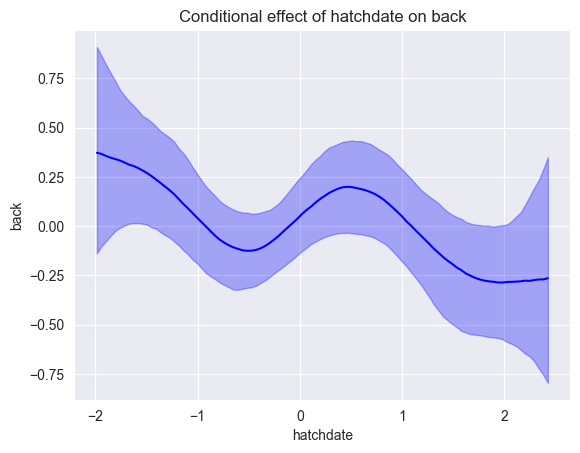

In [17]:
result = brms.call("conditional_effects", fit3, "hatchdate", resp="back")
df_result = result['back.back_hatchdate']

df_plot = df_result.sort_values("hatchdate")

fig, ax = plt.subplots()

ax.plot(
    df_plot["hatchdate"],
    df_plot["estimate__"],
    color="blue"
)

ax.fill_between(
    df_plot["hatchdate"],
    df_plot["lower__"],
    df_plot["upper__"],
    alpha=0.3,
    color="blue"
)

ax.set_xlabel("hatchdate")
ax.set_ylabel("back")
ax.set_title("Conditional effect of hatchdate on back")

plt.show()

reveals a non-linear relationship of hatchdate on the back color, which seems to change in waves over the course of the hatch dates.

There are many more modeling options for multivariate models, which are not discussed in this vignette. Examples include autocorrelation structures, Gaussian processes, or explicit non-linear predictors (e.g., see help("brmsformula") or vignette("brms_multilevel")). In fact, nearly all the flexibility of univariate models is retained in multivariate models.

## References

Hadfield JD, Nutall A, Osorio D, Owens IPF (2007). Testing the phenotypic gambit: phenotypic, genetic and environmental correlations of colour. Journal of Evolutionary Biology, 20(2), 549-557.